# Downloading Dependencies


In [2]:
#!pip install easyocr
#!pip install imutils


In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## Apply Grayscaling to Images

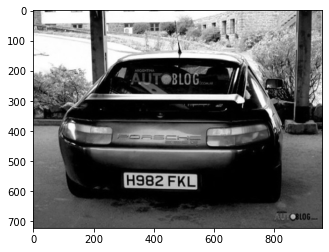

In [2]:
img = cv2.imread('image4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converts image to grayscale for opencv to read well
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)) #display image in matplotlib

## Apply filter and find edges for localization

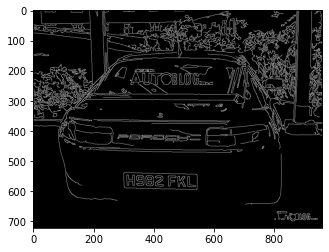

In [3]:
#edge detection to elliminate noise
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction(parameters specify how intensely the noise to be reduced)
edged = cv2.Canny(bfilter, 30, 200) #Edge detection(Canny algorithm)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## Find contours and apply Mask

In [15]:
#to find shapes within images, ideally a rectangle when its a number plate
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #find shapes aka contour
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] #returns top10 contours sorted descending, based on area

In [16]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True) #loop thru the "contours" array to find the shape of the contour using PolyDP fn
    if len(approx) == 4: ##if the variable has 4 keypoints or edges
        location = approx
        break

In [17]:
location #coordinates of the possible number plate


array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

In [18]:
mask = np.zeros(gray.shape, np.uint8) #creates blank mask or a template of exact shape as the image and filling with blank 0; aka black 
new_image = cv2.drawContours(mask, [location], 0,255, -1) #draw the contour via the location coordinates
new_image = cv2.bitwise_and(img, img, mask=mask) #overlays the mask over the actual image to focus on the number plate

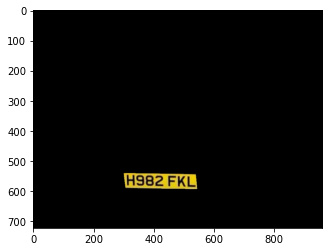

In [19]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [26]:
(x,y) = np.where(mask==255) #find coordinates where the x and y arent 0, aka the image aint black 
(x1, y1) = (np.min(x), np.min(y)) #for the top left coordinate
(x2, y2) = (np.max(x), np.max(y)) #for the bottom right coordinates
cropped_image = gray[x1:x2+1, y1:y2+1] #crop image accordingly

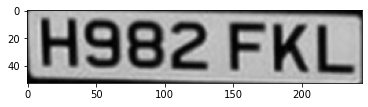

In [27]:

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## Use EasyOCR for text detection

In [28]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[0, 0], [244, 0], [244, 53], [0, 53]], 'H982 FKL', 0.9757375847177501)]

## Render Results

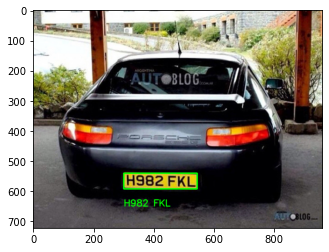

In [29]:
text = result[0][-2] #var to store the result(only the text)
font = cv2.FONT_HERSHEY_SIMPLEX

#overlay the text over the image in the following coordinates
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3) #draw the rectangle
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))  #show results

## Importing Files and Grayscaling Image


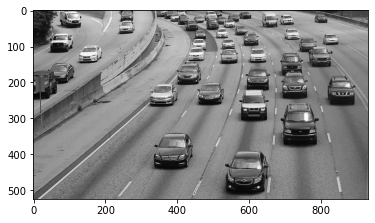

In [30]:
from PIL import Image
car_cascade_src = 'cars.xml'
image = cv2.imread('carparking.jpg')
car_cascade = cv2.CascadeClassifier(car_cascade_src)
grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(grey, cv2.COLOR_BGR2RGB)) 


## Applying Gaussian Blur

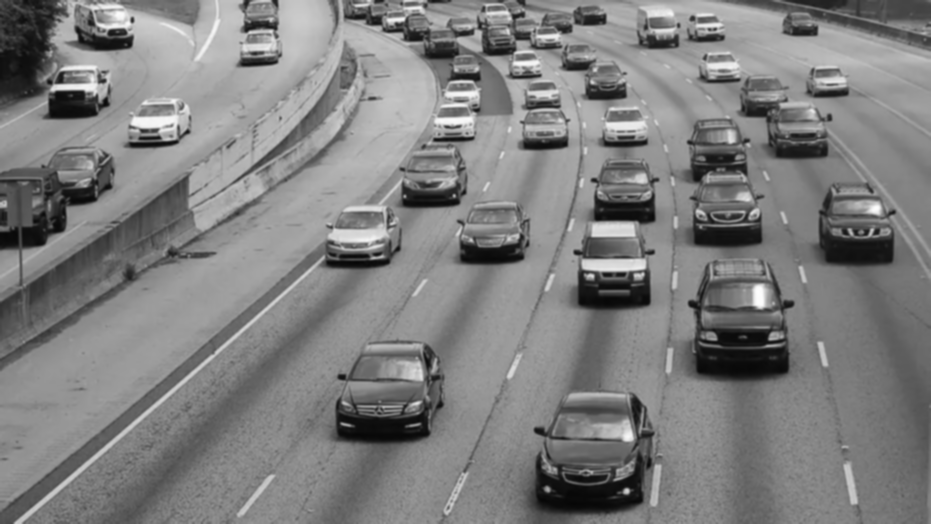

In [31]:
blur = cv2.GaussianBlur(grey,(5,5),0) #remove noise from the image for better pre processing 
Image.fromarray(blur)

## Dilation

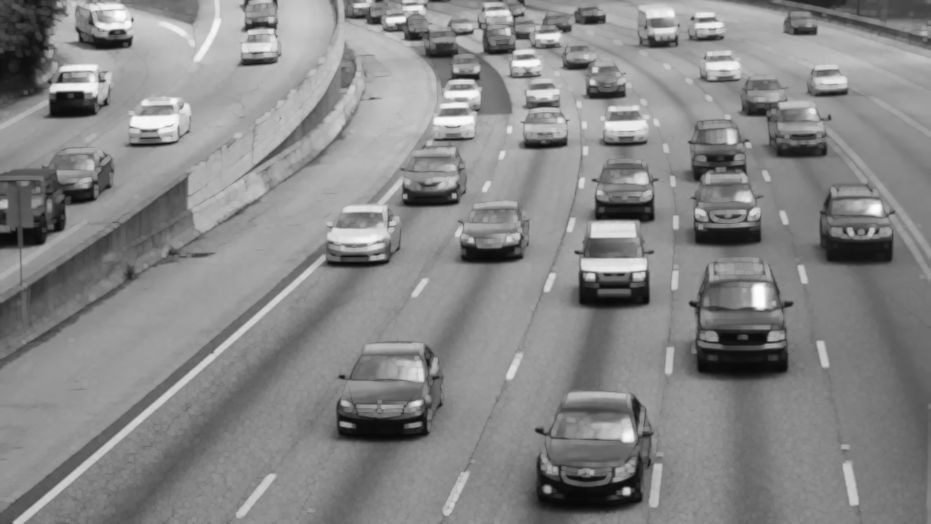

In [32]:
dilated = cv2.dilate(blur,np.ones((3,3)))   # fill the pixels with an element, to fill the missing parts of the images whenever needed.
Image.fromarray(dilated)

## Morphology-Ex, structuring element

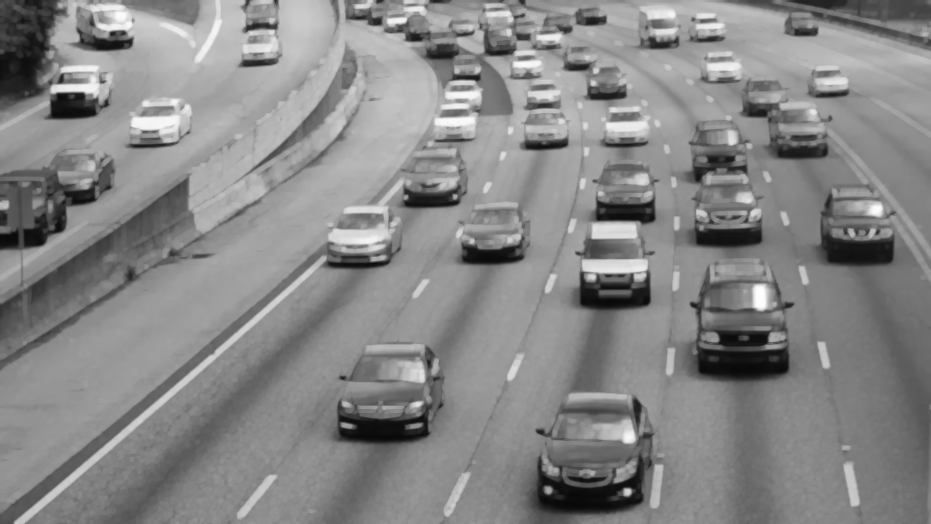

In [33]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel) 
Image.fromarray(closing)

## Car Detection Using Cascade

In [34]:
cars = car_cascade.detectMultiScale(closing, 1.1, 1) 
cars #shows approx coordinates of car in the image

array([[362,  87,  21,  21],
       [450,  14,  30,  30],
       [132,  84,  45,  45],
       [532,   4,  30,  30],
       [377,  10,  32,  32],
       [ 11, 201,  49,  49],
       [783,   5,  43,  43],
       [730,  83,  48,  48],
       [602,  88,  46,  46],
       [296, 328, 162, 162],
       [653, 254, 175, 175],
       [805,  63,  51,  51],
       [514,  67,  61,  61],
       [393, 150,  76,  76],
       [685,  10,  46,  46],
       [356, 124, 123, 123],
       [670, 163, 109, 109],
       [430, 186, 111, 111],
       [790, 169, 132, 132],
       [556, 128, 134, 134],
       [638,  12,  51,  51],
       [643, 130, 163, 163],
       [ 23,  49,  95,  95],
       [ 81,   7,  61,  61],
       [109,  94,  78,  78],
       [552, 220, 122, 122],
       [505, 100,  73,  73],
       [416,  23,  51,  51],
       [760, 102,  79,  79],
       [225,  21,  65,  65],
       [510,  21,  26,  26],
       [400,  21,  27,  27],
       [297, 178, 131, 131],
       [518,  19,  45,  45],
       [551,  

## Detect Car 

40  cars found


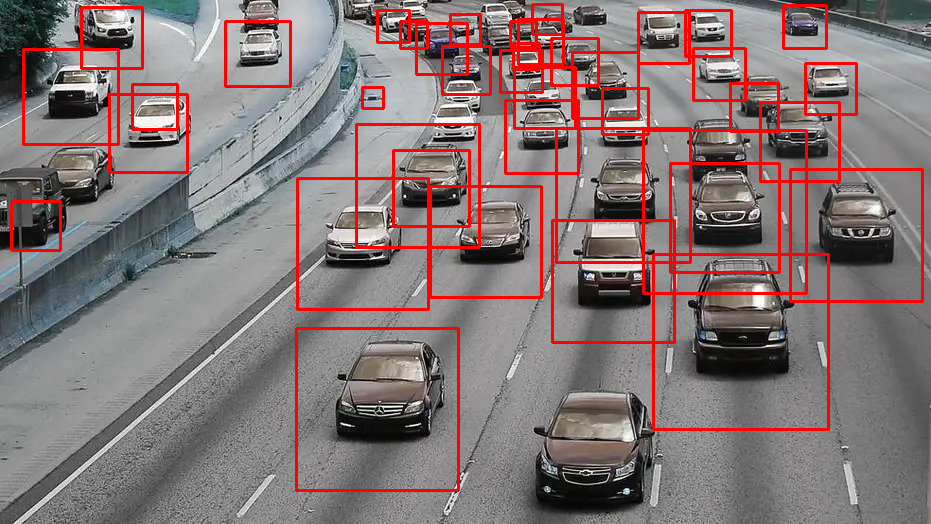

In [35]:
cnt = 0
for (x,y,w,h) in cars: #iterate thru coordinates, draw a rectangle in the possible coordinates
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    cnt += 1
print(cnt, " cars found")
Image.fromarray(image)